### Imports 

In [ ]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [ ]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [ ]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape) # (batch,  c, H, W) 
print(y.shape) # batch

torch.Size([128, 3, 32, 32])
torch.Size([128])


### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [ ]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader, name="checkpoint", verbose=True):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode        
        model.train()
        # TODO: Loop over the training set
        correct_count = 0.0
        total = 0.0
        for i, (batch_images, batch_labels) in enumerate(train_loader):
            # TODO: Put the inputs and targets on the write device
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # TODO: Feed forward to get the logits
            logits = model(batch_images)
            # TODO: Compute the loss and accuracy
            loss = criterion(logits, batch_labels)
            score, predicted = torch.max(logits, 1)
            correct_count += (predicted == batch_labels.view(-1)).double().sum()
            total += batch_labels.shape[0]
            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
        train_losses.append(loss.item())
        train_accuracies.append(correct_count.item()/total)
        
        # TODO: Switch the model to eval mode
        model.eval()

        correct_count = 0.0
        total = 0.0
        with torch.no_grad():
            # TODO: Loop over the validation set 
            val_loss = 0.0
            for i, (batch_images, batch_labels) in enumerate(val_loader):
                # TODO: Put the inputs and targets on the write device
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                # TODO: Feed forward to get the logits
                logits = model(batch_images)
                # TODO: Compute the loss and accuracy
                loss = criterion(logits, batch_labels)
                val_loss += loss.item() * batch_labels.shape[0]
                score, predicted = torch.max(logits, 1)
                correct_count += (predicted == batch_labels.view(-1)).double().sum()
                total += batch_labels.shape[0]
                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss/len(val_loader.dataset))
            val_accuracies.append(correct_count.item()/total)
        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          checkpoint = { 
            'epoch': t,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies}
          torch.save(checkpoint, 'drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break
        if verbose:
          print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
          print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val

### Q 2.2 Shallow convolutional network. 

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
      super().__init__()
      self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:

ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [ ]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        
        # TODO
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels = self.input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=8)
        self.view = View((-1,256))
        self.linear = nn.Linear(256, self.num_classes)

    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        output = self.conv1(x)
        output = self.relu(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool1(output)
        output = self.conv3(output)
        output = self.relu(output)
        output = self.pool2(output)
        output = self.view(output)
        output = self.linear(output)

        return output

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [ ]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(3, 10).to(device)
# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="ShallowConvNet_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 2.230127, [TRAIN ACCURACY]: 0.154
[EPOCH]: 0, [VAL LOSS]: 2.227868, [VAL ACCURACY]: 0.198 

[EPOCH]: 1, [TRAIN LOSS]: 2.195550, [TRAIN ACCURACY]: 0.231
[EPOCH]: 1, [VAL LOSS]: 2.147362, [VAL ACCURACY]: 0.245 

[EPOCH]: 2, [TRAIN LOSS]: 2.112414, [TRAIN ACCURACY]: 0.259
[EPOCH]: 2, [VAL LOSS]: 2.062458, [VAL ACCURACY]: 0.265 

[EPOCH]: 3, [TRAIN LOSS]: 2.051868, [TRAIN ACCURACY]: 0.275
[EPOCH]: 3, [VAL LOSS]: 1.974269, [VAL ACCURACY]: 0.283 

[EPOCH]: 4, [TRAIN LOSS]: 2.025833, [TRAIN ACCURACY]: 0.293
[EPOCH]: 4, [VAL LOSS]: 1.907984, [VAL ACCURACY]: 0.294 

[EPOCH]: 5, [TRAIN LOSS]: 1.926238, [TRAIN ACCURACY]: 0.307
[EPOCH]: 5, [VAL LOSS]: 1.814935, [VAL ACCURACY]: 0.304 

[EPOCH]: 6, [TRAIN LOSS]: 1.897580, [TRAIN ACCURACY]: 0.317
[EPOCH]: 6, [VAL LOSS]: 1.758194, [VAL ACCURACY]: 0.325 

[EPOCH]: 7, [TRAIN LOSS]: 1.921147, [TRAIN ACCURACY]: 0.327
[EPOCH]: 7, [VAL LOSS]: 1.702630, [VAL ACCURACY]: 0.331 

[EPOCH]: 8, [TRAIN LOSS]: 1.940462, [TRAIN ACCURACY]: 0.

In [ ]:
name = "ShallowConvNet_checkpoint"
train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
val_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_accuracies"]

Text(0, 0.5, 'accuracy')

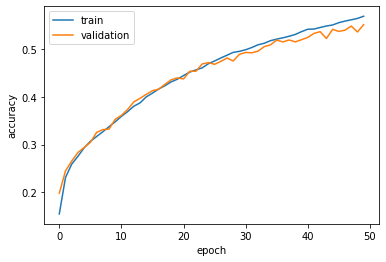

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies, "-", label = "train")
plt.plot(range(len(val_accuracies)), val_accuracies, "-", label = "validation")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")

### Q2.4 Simple convolution network

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [ ]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.input_channels = input_channels
        self.num_classes = num_classes

        # (batch, 3, 32, 32) -> (batch, 64, 32, 32) # (32 + 2*2 - 5)/1 + 1 = 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU()
        )

        # (batch, 64, 32, 32) -> (batch, 64, 16, 16) # (32 + 2*1 - 3)/1 + 1 = 32
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        

        # (batch, 64, 16, 16) -> (batch, 128, 16, 16) -> (batch, 128, 8, 8)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        

        # (batch, 128, 8, 8) -> (batch, 256, 8, 8) -> (batch, 256, 1, 1)
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(8)
        )

        # 1 -> C
        self.linear = nn.Linear(256, self.num_classes)

    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        output = self.conv(x)

        # HINT: block of 3 conv 
        output = self.block1(output)

        # HINT : block of 3 conv
        output = self.block2(output)

        # HINT: block of 3 conv 
        output = self.block3(output).view(-1, 256)

        # HINT: projection 
        output = self.linear(output)
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(3, 10).to(device)
# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="SimpleConvNet_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 2.301408, [TRAIN ACCURACY]: 0.099
[EPOCH]: 0, [VAL LOSS]: 2.305155, [VAL ACCURACY]: 0.103 

[EPOCH]: 1, [TRAIN LOSS]: 2.301211, [TRAIN ACCURACY]: 0.099
[EPOCH]: 1, [VAL LOSS]: 2.305034, [VAL ACCURACY]: 0.103 

[EPOCH]: 2, [TRAIN LOSS]: 2.309426, [TRAIN ACCURACY]: 0.099
[EPOCH]: 2, [VAL LOSS]: 2.304929, [VAL ACCURACY]: 0.103 

[EPOCH]: 3, [TRAIN LOSS]: 2.306191, [TRAIN ACCURACY]: 0.099
[EPOCH]: 3, [VAL LOSS]: 2.304826, [VAL ACCURACY]: 0.103 

[EPOCH]: 4, [TRAIN LOSS]: 2.307474, [TRAIN ACCURACY]: 0.099
[EPOCH]: 4, [VAL LOSS]: 2.304726, [VAL ACCURACY]: 0.103 

[EPOCH]: 5, [TRAIN LOSS]: 2.303677, [TRAIN ACCURACY]: 0.099
[EPOCH]: 5, [VAL LOSS]: 2.304636, [VAL ACCURACY]: 0.103 



### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

In [ ]:
name = "SimpleConvNet_checkpoint"
simple_val_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_accuracies"]
simple_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

name = "ShallowConvNet_checkpoint"
shallow_val_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_accuracies"]
shallow_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

In [ ]:
print(shallow_val_accuracies[-1], simple_val_accuracies[-1])

0.5516 0.1026


ShallowNet achieves accuracy of $55.2\%$ on the validation set, while SimpleConvnet fails to train and achieves only $10.3\%$ on the validation set. This is because SimpleConvnet has a very deep structure and back propagation fails to learn anything because of the weak gradient signals. 

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [ ]:
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        
        # TODO
        self.input_channels = input_channels
        self.num_classes = num_classes

        # (batch, 3, 32, 32) -> (batch, 64, 32, 32) # (32 + 2*2 - 5)/1 + 1 = 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # (batch, 64, 32, 32) -> (batch, 64, 16, 16) # (32 + 2*1 - 3)/1 + 1 = 32
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        

        # (batch, 64, 16, 16) -> (batch, 128, 16, 16) -> (batch, 128, 8, 8)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        

        # (batch, 128, 8, 8) -> (batch, 256, 8, 8) -> (batch, 256, 1, 1)
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(8)
        )

        # 1 -> C
        self.linear = nn.Linear(256, self.num_classes)

    def forward(self, x):
       
        # HINT: first conv layer 
        output = self.conv(x)

        # HINT: block of 3 conv 
        output = self.block1(output)

        # HINT : block of 3 conv
        output = self.block2(output)

        # HINT: block of 3 conv 
        output = self.block3(output).view(-1, 256)

        # HINT: projection 
        output = self.linear(output)
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(3, 10).to(device)
# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="SimpleConvNet2_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.379928, [TRAIN ACCURACY]: 0.346
[EPOCH]: 0, [VAL LOSS]: 1.271565, [VAL ACCURACY]: 0.429 

[EPOCH]: 1, [TRAIN LOSS]: 1.196116, [TRAIN ACCURACY]: 0.490
[EPOCH]: 1, [VAL LOSS]: 1.090821, [VAL ACCURACY]: 0.506 

[EPOCH]: 2, [TRAIN LOSS]: 1.148992, [TRAIN ACCURACY]: 0.559
[EPOCH]: 2, [VAL LOSS]: 0.937084, [VAL ACCURACY]: 0.541 

[EPOCH]: 3, [TRAIN LOSS]: 1.228272, [TRAIN ACCURACY]: 0.614
[EPOCH]: 3, [VAL LOSS]: 0.854227, [VAL ACCURACY]: 0.568 

[EPOCH]: 4, [TRAIN LOSS]: 0.906024, [TRAIN ACCURACY]: 0.662
[EPOCH]: 4, [VAL LOSS]: 0.743354, [VAL ACCURACY]: 0.587 

[EPOCH]: 5, [TRAIN LOSS]: 0.824018, [TRAIN ACCURACY]: 0.704
[EPOCH]: 5, [VAL LOSS]: 0.722476, [VAL ACCURACY]: 0.603 

[EPOCH]: 6, [TRAIN LOSS]: 0.800597, [TRAIN ACCURACY]: 0.740
[EPOCH]: 6, [VAL LOSS]: 0.821646, [VAL ACCURACY]: 0.610 

[EPOCH]: 7, [TRAIN LOSS]: 0.731457, [TRAIN ACCURACY]: 0.774
[EPOCH]: 7, [VAL LOSS]: 0.761048, [VAL ACCURACY]: 0.612 

[EPOCH]: 8, [TRAIN LOSS]: 0.622690, [TRAIN ACCURACY]: 0.

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

In [ ]:
name = "SimpleConvNet_checkpoint"
simple_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
simple_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

name = "SimpleConvNet2_checkpoint"
simple2_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
simple2_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

Text(0, 0.5, 'training accuracy')

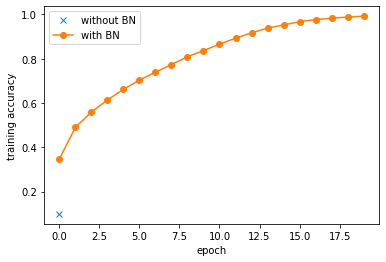

In [ ]:
plt.plot(range(len(simple_train_accuracies)), simple_train_accuracies, "x", label = "without BN")
plt.plot(range(len(simple2_train_accuracies)), simple2_train_accuracies, "o-", label = "with BN")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("training accuracy")

Text(0, 0.5, 'training loss')

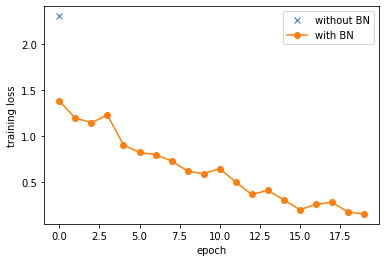

In [ ]:
plt.plot(range(len(simple_train_losses)), simple_train_losses, "x", label = "without BN")
plt.plot(range(len(simple2_train_losses)), simple2_train_losses, "o-", label = "with BN")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("training loss")

As we can see, after adding batch normalization the training a model with a deep structure becomes successfull. Thus we observe that batch normalization is able to accelerate the training of very deep networks and stabilize the learning process.

#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [ ]:
model = SimpleConvnet(3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="SimpleConvNet_Adam_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.580743, [TRAIN ACCURACY]: 0.299
[EPOCH]: 0, [VAL LOSS]: 1.495503, [VAL ACCURACY]: 0.404 

[EPOCH]: 1, [TRAIN LOSS]: 1.417854, [TRAIN ACCURACY]: 0.447
[EPOCH]: 1, [VAL LOSS]: 1.096793, [VAL ACCURACY]: 0.495 

[EPOCH]: 2, [TRAIN LOSS]: 1.303514, [TRAIN ACCURACY]: 0.512
[EPOCH]: 2, [VAL LOSS]: 1.041733, [VAL ACCURACY]: 0.542 

[EPOCH]: 3, [TRAIN LOSS]: 1.075999, [TRAIN ACCURACY]: 0.563
[EPOCH]: 3, [VAL LOSS]: 1.094810, [VAL ACCURACY]: 0.560 

[EPOCH]: 4, [TRAIN LOSS]: 1.139477, [TRAIN ACCURACY]: 0.607
[EPOCH]: 4, [VAL LOSS]: 0.877000, [VAL ACCURACY]: 0.585 

[EPOCH]: 5, [TRAIN LOSS]: 1.170268, [TRAIN ACCURACY]: 0.646
[EPOCH]: 5, [VAL LOSS]: 1.027464, [VAL ACCURACY]: 0.597 

[EPOCH]: 6, [TRAIN LOSS]: 0.736144, [TRAIN ACCURACY]: 0.679
[EPOCH]: 6, [VAL LOSS]: 0.699818, [VAL ACCURACY]: 0.623 

[EPOCH]: 7, [TRAIN LOSS]: 1.019519, [TRAIN ACCURACY]: 0.713
[EPOCH]: 7, [VAL LOSS]: 0.637367, [VAL ACCURACY]: 0.652 

[EPOCH]: 8, [TRAIN LOSS]: 1.053925, [TRAIN ACCURACY]: 0.

In [ ]:
model = SimpleConvnet2(3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="SimpleConvNet2_Adam_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.208938, [TRAIN ACCURACY]: 0.482
[EPOCH]: 0, [VAL LOSS]: 0.954393, [VAL ACCURACY]: 0.587 

[EPOCH]: 1, [TRAIN LOSS]: 1.102229, [TRAIN ACCURACY]: 0.665
[EPOCH]: 1, [VAL LOSS]: 0.834982, [VAL ACCURACY]: 0.659 

[EPOCH]: 2, [TRAIN LOSS]: 0.599654, [TRAIN ACCURACY]: 0.750
[EPOCH]: 2, [VAL LOSS]: 0.563942, [VAL ACCURACY]: 0.697 

[EPOCH]: 3, [TRAIN LOSS]: 0.671206, [TRAIN ACCURACY]: 0.821
[EPOCH]: 3, [VAL LOSS]: 0.400023, [VAL ACCURACY]: 0.715 

[EPOCH]: 4, [TRAIN LOSS]: 0.377684, [TRAIN ACCURACY]: 0.882
[EPOCH]: 4, [VAL LOSS]: 0.224401, [VAL ACCURACY]: 0.736 

[EPOCH]: 5, [TRAIN LOSS]: 0.462483, [TRAIN ACCURACY]: 0.934
[EPOCH]: 5, [VAL LOSS]: 0.259081, [VAL ACCURACY]: 0.742 

[EPOCH]: 6, [TRAIN LOSS]: 0.141229, [TRAIN ACCURACY]: 0.971
[EPOCH]: 6, [VAL LOSS]: 0.434780, [VAL ACCURACY]: 0.736 

[EPOCH]: 7, [TRAIN LOSS]: 0.078013, [TRAIN ACCURACY]: 0.991
[EPOCH]: 7, [VAL LOSS]: 0.300876, [VAL ACCURACY]: 0.745 

[EPOCH]: 8, [TRAIN LOSS]: 0.175445, [TRAIN ACCURACY]: 0.

In [ ]:
name = "SimpleConvNet_Adam_checkpoint"
simple_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
simple_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

name = "SimpleConvNet2_Adam_checkpoint"
simple2_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
simple2_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

Text(0, 0.5, 'training accuracy')

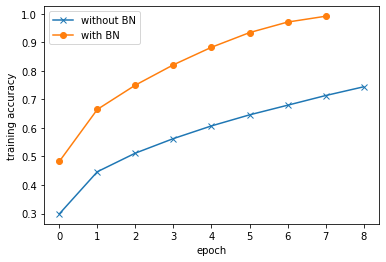

In [ ]:
plt.plot(range(len(simple_train_accuracies)), simple_train_accuracies, "x-", label = "without BN")
plt.plot(range(len(simple2_train_accuracies)), simple2_train_accuracies, "o-", label = "with BN")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("training accuracy")

Text(0, 0.5, 'training loss')

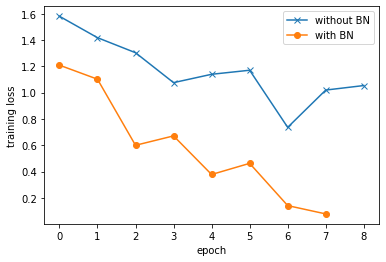

In [ ]:
plt.plot(range(len(simple_train_losses)), simple_train_losses, "x-", label = "without BN")
plt.plot(range(len(simple2_train_losses)), simple2_train_losses, "o-", label = "with BN")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("training loss")

Once we start using Adam with a smaller learning rate, we can see that training without batch normalization is successful as well. Moreover, using this optimizer has allowed us to on the validation set achieve a higher accuracy ($74.5\%$) with the model with batch normalization compared to SGD ($65.3\%$). 

#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


In [ ]:
first_batch = next(iter(train_loader))

model = SimpleConvnet2(3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i, (batch_images, batch_labels) in enumerate([first_batch] * 50):
  batch_images = batch_images.to(device)
  batch_labels = batch_labels.to(device)
  logits = model(batch_images)
  loss = criterion(logits, batch_labels)
  score, predicted = torch.max(logits, 1)
  correct = (predicted == batch_labels.view(-1)).double().sum()
  total = batch_labels.shape[0]
  accuracy = correct.item() / total
  print("Accuracy: {}".format(accuracy))
  if accuracy == 1:
    print("Overfitting: achieved 100% accuracy on the batch!")
    break
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


    

Accuracy: 0.109375
Accuracy: 0.3828125
Accuracy: 0.84375
Accuracy: 0.9296875
Accuracy: 1.0
Overfitting: achieved 100% accuracy on the batch!


### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [ ]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        
        # TODO
        self.input_channels = input_channels
        self.num_classes = num_classes

        # (batch, 3, 32, 32) -> (batch, 64, 32, 32) 
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )


        self.reshape1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.block1_s = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block1_e = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )


        self.reshape2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.block2_s = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block2_e = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )


        self.reshape3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.block3_s = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block3_e = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.MaxPool2d(8)
        )

        self.linear = nn.Linear(256 ,self.num_classes)
        
    def forward(self, x):
        
        # TODO
        output = self.conv(x)
        residual = output.clone()
        residual = self.reshape1(residual)
        output = self.block1_s(output) 
        output = torch.add(residual, output)
        output = self.block1_e(output)

        residual = output.clone()
        residual = self.reshape2(residual)
        output = self.block2_s(output)
        output = torch.add(residual, output)
        output = self.block2_e(output)

        residual = output.clone()
        residual = self.reshape3(residual)
        output = self.block3_s(output)
        output = torch.add(residual, output)
        output = self.block3_e(output)

        output = self.linear(output.view(-1,256))
        return output
        

In [ ]:
model = ResidualConvnet(3, 10).to(device)
x = torch.randn(128, 3, 32 ,32).to(device)
model(x).shape

torch.Size([128, 10])

In [ ]:
first_batch = next(iter(train_loader))

model = ResidualConvnet(3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i, (batch_images, batch_labels) in enumerate([first_batch] * 200):
  batch_images = batch_images.to(device)
  batch_labels = batch_labels.to(device)
  logits = model(batch_images)
  loss = criterion(logits, batch_labels)
  score, predicted = torch.max(logits, 1)
  correct = (predicted == batch_labels.view(-1)).double().sum()
  total = batch_labels.shape[0]
  accuracy = correct.item() / total
  print("Accuracy: {}".format(accuracy))
  if accuracy == 1:
    print("Overfitting: achieved 100% accuracy on the batch!")
    break
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


    

Accuracy: 0.109375
Accuracy: 0.28125
Accuracy: 0.640625
Accuracy: 0.828125
Accuracy: 0.9375
Accuracy: 0.984375
Accuracy: 0.9921875
Accuracy: 1.0
Overfitting: achieved 100% accuracy on the batch!


In [ ]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(3, 10).to(device)
# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="ResidualConvnet_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.180701, [TRAIN ACCURACY]: 0.516
[EPOCH]: 0, [VAL LOSS]: 1.080625, [VAL ACCURACY]: 0.626 

[EPOCH]: 1, [TRAIN LOSS]: 0.958589, [TRAIN ACCURACY]: 0.680
[EPOCH]: 1, [VAL LOSS]: 0.881987, [VAL ACCURACY]: 0.690 

[EPOCH]: 2, [TRAIN LOSS]: 0.782816, [TRAIN ACCURACY]: 0.755
[EPOCH]: 2, [VAL LOSS]: 0.732858, [VAL ACCURACY]: 0.749 

[EPOCH]: 3, [TRAIN LOSS]: 0.640761, [TRAIN ACCURACY]: 0.801
[EPOCH]: 3, [VAL LOSS]: 0.688632, [VAL ACCURACY]: 0.757 

[EPOCH]: 4, [TRAIN LOSS]: 0.461377, [TRAIN ACCURACY]: 0.838
[EPOCH]: 4, [VAL LOSS]: 0.616553, [VAL ACCURACY]: 0.789 

[EPOCH]: 5, [TRAIN LOSS]: 0.437509, [TRAIN ACCURACY]: 0.867
[EPOCH]: 5, [VAL LOSS]: 0.609799, [VAL ACCURACY]: 0.787 

[EPOCH]: 6, [TRAIN LOSS]: 0.296813, [TRAIN ACCURACY]: 0.888
[EPOCH]: 6, [VAL LOSS]: 0.580287, [VAL ACCURACY]: 0.800 

[EPOCH]: 7, [TRAIN LOSS]: 0.316561, [TRAIN ACCURACY]: 0.911
[EPOCH]: 7, [VAL LOSS]: 0.545869, [VAL ACCURACY]: 0.815 

[EPOCH]: 8, [TRAIN LOSS]: 0.249055, [TRAIN ACCURACY]: 0.

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

In [ ]:
name = "SimpleConvNet2_Adam_checkpoint"
simple2_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
simple2_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

name = "ResidualConvnet_checkpoint"
res_train_accuracies = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_accuracies"]
res_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

Text(0, 0.5, 'training accuracy')

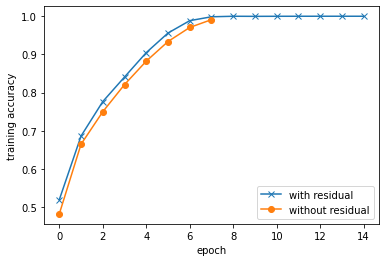

In [ ]:
plt.plot(range(len(res_train_accuracies)), res_train_accuracies, "x-", label = "with residual")
plt.plot(range(len(simple2_train_accuracies)), simple2_train_accuracies, "o-", label = "without residual")
plt.legend(loc="lower right")
plt.xlabel("epoch")
plt.ylabel("training accuracy")

Text(0, 0.5, 'training loss')

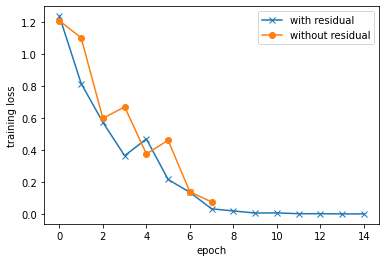

In [ ]:
plt.plot(range(len(res_train_losses)), res_train_losses, "x-", label = "with residual")
plt.plot(range(len(simple2_train_losses)), simple2_train_losses, "o-", label = "without residual")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("training loss")

As we can see, adding residual connections allowed us to train faster, which can be seen from that its training accuracy curve is above the other training curve (no skip connections) at every epoch and its training loss curve is steeper.

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [ ]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052]),
                                      ])


In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

In [ ]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(3, 10).to(device)
# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, _ = train_loop(model, criterion, optimizer, train_loader, val_loader, name="augmented_ResidualConvnet_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.205170, [TRAIN ACCURACY]: 0.513
[EPOCH]: 0, [VAL LOSS]: 1.093803, [VAL ACCURACY]: 0.609 

[EPOCH]: 1, [TRAIN LOSS]: 1.061672, [TRAIN ACCURACY]: 0.672
[EPOCH]: 1, [VAL LOSS]: 0.911562, [VAL ACCURACY]: 0.679 

[EPOCH]: 2, [TRAIN LOSS]: 0.697274, [TRAIN ACCURACY]: 0.743
[EPOCH]: 2, [VAL LOSS]: 0.775755, [VAL ACCURACY]: 0.727 

[EPOCH]: 3, [TRAIN LOSS]: 0.523395, [TRAIN ACCURACY]: 0.790
[EPOCH]: 3, [VAL LOSS]: 0.735797, [VAL ACCURACY]: 0.743 

[EPOCH]: 4, [TRAIN LOSS]: 0.633179, [TRAIN ACCURACY]: 0.826
[EPOCH]: 4, [VAL LOSS]: 0.636446, [VAL ACCURACY]: 0.773 

[EPOCH]: 5, [TRAIN LOSS]: 0.598892, [TRAIN ACCURACY]: 0.855
[EPOCH]: 5, [VAL LOSS]: 0.627435, [VAL ACCURACY]: 0.781 

[EPOCH]: 6, [TRAIN LOSS]: 0.421343, [TRAIN ACCURACY]: 0.879
[EPOCH]: 6, [VAL LOSS]: 0.607364, [VAL ACCURACY]: 0.786 

[EPOCH]: 7, [TRAIN LOSS]: 0.340860, [TRAIN ACCURACY]: 0.902
[EPOCH]: 7, [VAL LOSS]: 0.555862, [VAL ACCURACY]: 0.808 

[EPOCH]: 8, [TRAIN LOSS]: 0.364303, [TRAIN ACCURACY]: 0.

In [ ]:
name = "ResidualConvnet_checkpoint"
res_val_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_losses"]
res_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

name = "augmented_ResidualConvnet_checkpoint"
aug_val_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_losses"]
aug_train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]

Text(0.5, 1.0, 'with data augementation')

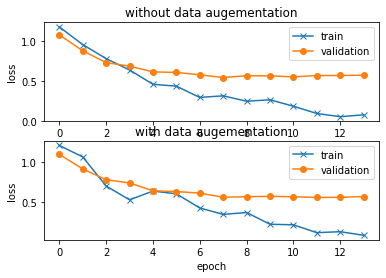

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(len(res_train_losses)), res_train_losses, "x-", label = "train")
plt.plot(range(len(res_val_losses)), res_val_losses, "o-", label = "validation")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("without data augementation")

plt.subplot(2,1,2)
plt.plot(range(len(aug_train_losses)), aug_train_losses, "x-", label = "train")
plt.plot(range(len(aug_val_losses)), aug_val_losses, "o-", label = "validation")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("with data augementation")


For data augmentation, I used random horizontal flip and color jittering. As we can see, the gap between the train and loss curves reduces thus data augmentation reduced overfitting of the model. Also, we achived $> 80\%$ accuracy on the validation set which was not achieved without data augmentation by the same model. Also, notice that the training accuracy never achieved $100\%$, which also shows that the model did not overfit.

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
def train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader, name="checkpoint", verbose=True):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    scheduler : Instance of scheduler class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode        
        model.train()
        # TODO: Loop over the training set
        correct_count = 0.0
        total = 0.0
        for i, (batch_images, batch_labels) in enumerate(train_loader):
            # TODO: Put the inputs and targets on the write device
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # TODO: Feed forward to get the logits
            logits = model(batch_images)
            # TODO: Compute the loss and accuracy
            loss = criterion(logits, batch_labels)
            score, predicted = torch.max(logits, 1)
            correct_count += (predicted == batch_labels.view(-1)).double().sum()
            total += batch_labels.shape[0]
            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
        train_losses.append(loss.item())
        train_accuracies.append(correct_count.item()/total)
        
        # TODO: Switch the model to eval mode
        model.eval()

        correct_count = 0.0
        total = 0.0
        with torch.no_grad():
            # TODO: Loop over the validation set 
            val_loss = 0.0
            for i, (batch_images, batch_labels) in enumerate(val_loader):
                # TODO: Put the inputs and targets on the write device
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                # TODO: Feed forward to get the logits
                logits = model(batch_images)
                # TODO: Compute the loss and accuracy
                loss = criterion(logits, batch_labels)
                val_loss += loss.item() * batch_labels.shape[0]
                score, predicted = torch.max(logits, 1)
                correct_count += (predicted == batch_labels.view(-1)).double().sum()
                total += batch_labels.shape[0]
                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss/len(val_loader.dataset))
            val_accuracies.append(correct_count.item()/total)
        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          checkpoint = { 
            'epoch': t,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies}
          torch.save(checkpoint, 'drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break
        if verbose:
          print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
          print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

        # TODO : scheduler step
        scheduler.step()
    return train_losses, train_accuracies, val_losses, val_accuracies, best_val

In [ ]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(3, 10).to(device)
# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
# TODO : Initialize the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies, best_val = train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader, name="ResidualConvnet_scheduler_checkpoint")

[EPOCH]: 0, [TRAIN LOSS]: 1.783707, [TRAIN ACCURACY]: 0.312
[EPOCH]: 0, [VAL LOSS]: 3.087098, [VAL ACCURACY]: 0.415 

[EPOCH]: 1, [TRAIN LOSS]: 1.490655, [TRAIN ACCURACY]: 0.479
[EPOCH]: 1, [VAL LOSS]: 1.363020, [VAL ACCURACY]: 0.537 

[EPOCH]: 2, [TRAIN LOSS]: 1.038968, [TRAIN ACCURACY]: 0.575
[EPOCH]: 2, [VAL LOSS]: 1.498401, [VAL ACCURACY]: 0.591 

[EPOCH]: 3, [TRAIN LOSS]: 0.882802, [TRAIN ACCURACY]: 0.646
[EPOCH]: 3, [VAL LOSS]: 290.696880, [VAL ACCURACY]: 0.634 

[EPOCH]: 4, [TRAIN LOSS]: 0.867906, [TRAIN ACCURACY]: 0.701
[EPOCH]: 4, [VAL LOSS]: 2.988466, [VAL ACCURACY]: 0.695 

[EPOCH]: 5, [TRAIN LOSS]: 0.677529, [TRAIN ACCURACY]: 0.743
[EPOCH]: 5, [VAL LOSS]: 0.754086, [VAL ACCURACY]: 0.745 

[EPOCH]: 6, [TRAIN LOSS]: 0.721982, [TRAIN ACCURACY]: 0.773
[EPOCH]: 6, [VAL LOSS]: 2.289733, [VAL ACCURACY]: 0.723 

[EPOCH]: 7, [TRAIN LOSS]: 0.739100, [TRAIN ACCURACY]: 0.781
[EPOCH]: 7, [VAL LOSS]: 0.709980, [VAL ACCURACY]: 0.758 

[EPOCH]: 8, [TRAIN LOSS]: 0.843211, [TRAIN ACCURACY]: 

Using StepLR, we are able to achieve $84.9\%$ accuracy on the validation set.

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





In [ ]:
def tuning(parameters, mode):
  model = ResidualConvnet(3, 10).to(device)
  criterion = nn.CrossEntropyLoss()
  
  if mode == "Adam":
    for lr in parameters:
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      _, _, _, _, best_val = train_loop(model, criterion, optimizer, train_loader, val_loader, name="ResidualConvnet_{}_{}_checkpoint".format(mode, lr), verbose=False)
      print("mode: {}, learning rate: {}, val acc: {}".format(mode, lr, best_val))
  elif mode == "SGD":
    for lr in parameters:
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)
      _, _, _, _, best_val = train_loop(model, criterion, optimizer, train_loader, val_loader, name="ResidualConvnet_{}_{}_checkpoint".format(mode, lr), verbose=False)
      print("mode: {}, learning rate: {}, val acc: {}".format(mode, lr, best_val))
  elif mode == "StepLR":
    for gamma in parameters:
      optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
      scheduler = StepLR(optimizer, step_size=10, gamma=gamma)
      _, _, _, _, best_val = train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader, name="ResidualConvnet_{}_{}_checkpoint".format(mode, gamma), verbose=False)
      print("mode: {}, gamma: {}, val acc: {}".format(mode, gamma, best_val))

In [ ]:
def plot_curves(parameters, mode, plot_train=True):
  trains = []
  vals = []
  for parameter in parameters:
    name = "ResidualConvnet_{}_{}_checkpoint".format(mode, parameter)
    val_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["val_losses"]
    train_losses = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["train_losses"]
    trains.append(train_losses)
    vals.append(val_losses)

  if plot_train:
    for parameter, loss in zip(parameters, trains):
      plt.plot(range(len(loss)), loss, label=str(parameter))
    plt.legend()
    plt.title(mode)
    plt.xlabel("train")
  else:
    for parameter, loss in zip(parameters, vals):
      plt.plot(range(len(loss)), loss, label=str(parameter))
    plt.legend()
    plt.title(mode)
    plt.xlabel("val")


#### SGD

In [ ]:
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 5e-4]
tuning(parameters=lrs, mode="SGD")


mode: SGD, learning rate: 0.001, val acc: 0.7456


mode: SGD, learning rate: 0.005, val acc: 0.787


mode: SGD, learning rate: 0.01, val acc: 0.8191


mode: SGD, learning rate: 0.05, val acc: 0.8862


mode: SGD, learning rate: 0.0005, val acc: 0.8866


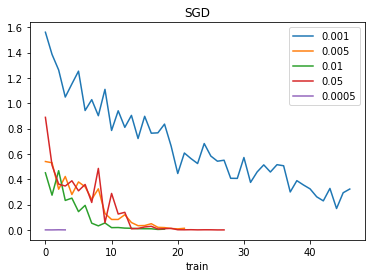

In [ ]:
plot_curves(parameters=lrs, mode="SGD", plot_train=True)

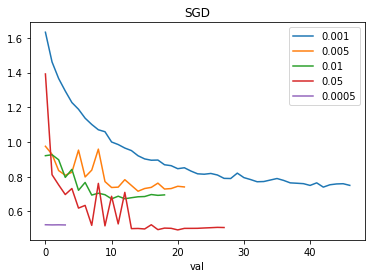

In [ ]:
plot_curves(parameters=lrs, mode="SGD", plot_train=False)

#### Adam

In [ ]:
lrs = [1e-4, 1e-5, 5e-3, 5e-5, 5e-4]
tuning(parameters=lrs, mode="Adam")

mode: Adam, learning rate: 0.0001, val acc: 0.8293


mode: Adam, learning rate: 1e-05, val acc: 0.8506


mode: Adam, learning rate: 0.005, val acc: 0.8627


mode: Adam, learning rate: 5e-05, val acc: 0.8902


mode: Adam, learning rate: 0.0005, val acc: 0.8922


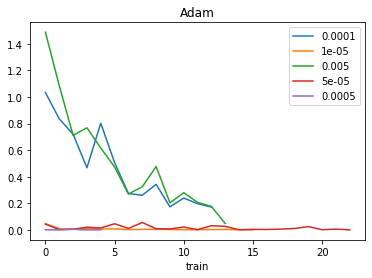

In [ ]:
plot_curves(parameters=lrs, mode="Adam", plot_train=True)

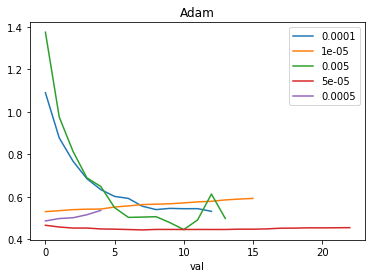

In [ ]:
plot_curves(parameters=lrs, mode="Adam", plot_train=False)

#### StepLR

In [ ]:
gammas = [0.1, 0.15, 0.05, 0.2, 0.25]
tuning(parameters=gammas, mode="StepLR")

mode: StepLR, gamma: 0.1, val acc: 0.8437


mode: StepLR, gamma: 0.15, val acc: 0.8555


mode: StepLR, gamma: 0.05, val acc: 0.8296


mode: StepLR, gamma: 0.2, val acc: 0.8267


mode: StepLR, gamma: 0.25, val acc: 0.8609


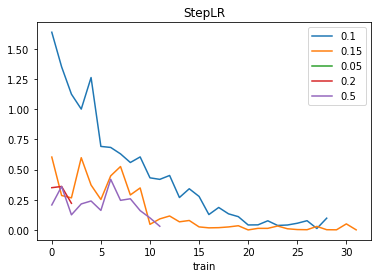

In [ ]:
plot_curves(parameters=[0.1, 0.15, 0.05, 0.2, 0.5], mode="StepLR", plot_train=True)

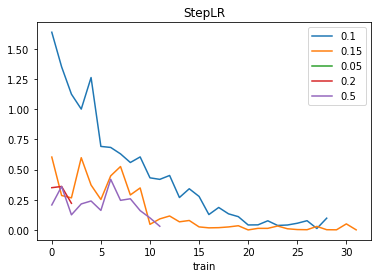

In [ ]:
plot_curves(parameters=[0.1, 0.15, 0.05, 0.2, 0.5], mode="StepLR", plot_train=True)

### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

The best model is trained with Adam with $\gamma = 5\times 10^{-4}$, it achieves $89.2\%$ accuracy on the validation set.

In [ ]:
name = "ResidualConvnet_{}_{}_checkpoint".format("Adam", 5e-4)
weights = torch.load('drive/My Drive/DS1008/HW2/model_checkpoints/{}.pth'.format(name))["model"]
model = ResidualConvnet(3, 10).to(device)
model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss(reduction="sum")
correct_count = 0.0
total = 0.0
with torch.no_grad():
    loss = 0.0
    for i, (batch_images, batch_labels) in enumerate(test_loader):
        # TODO: Put the inputs and targets on the write device
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # TODO: Feed forward to get the logits
        logits = model(batch_images)
        # TODO: Compute the loss and accuracy
        loss += criterion(logits, batch_labels)
        score, predicted = torch.max(logits, 1)
        correct_count += (predicted == batch_labels.view(-1)).double().sum()
        total += batch_labels.shape[0]
print("Accuracy: {}".format(correct_count/total))
print("Loss: {}".format(loss/len(test_loader.dataset)))

Accuracy: 0.891
Loss: 0.5469289422035217
